### Import libraries

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, classification_report

### Import data

In [143]:
df = pd.read_csv('/workspaces/heart-disease-prediction-system/data/heart_disease_uci.csv')
df.sample(3)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
681,682,61,Male,Switzerland,asymptomatic,105.0,0.0,NaN,normal,110.0,True,1.5,upsloping,NaN,NaN,1
459,460,55,Female,Hungary,atypical angina,110.0,344.0,False,st-t abnormality,160.0,False,0.0,NaN,NaN,NaN,0
158,159,60,Male,Cleveland,asymptomatic,140.0,293.0,False,lv hypertrophy,170.0,False,1.2,flat,2.0,reversable defect,2


In [144]:
df['target'] = (df.num>0).astype(int)
del df['num']

### EDA

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  target    920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [146]:
df.target.value_counts(normalize=True)

target
1    0.553261
0    0.446739
Name: proportion, dtype: float64

In [147]:
categorical_columns = list(df.dtypes[df.dtypes == "object"].index)
categorical_columns

['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [148]:
numerical_columns = [col for col in list(df.dtypes[df.dtypes!="object"].index) if col not in {"id","target"}]
numerical_columns

['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

##### fill missing value for numerical columns with median value

In [149]:
for col in numerical_columns:
    df[col] = df[col].fillna(df[col].median())

##### fill missing value for categorical columns with mode

In [162]:
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

### Prepare train, tets, val datasets

In [164]:
df_full_train, df_test = train_test_split(df,test_size=0.2,random_state=1)
len(df_full_train), len(df_test)

df_train, df_val = train_test_split(df_full_train, test_size=0.25,random_state=1)
len(df_train), len(df_val)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

del df_train['target']
del df_val['target']
del df_test['target']

##### Train Models

In [170]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [184]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

X_val_scaled = scaler.transform(X_val)

y_pred = model.predict_proba(X_val_scaled)[:, 1]

In [185]:
fpr,tpr,thresholds = roc_curve(y_val,y_pred)

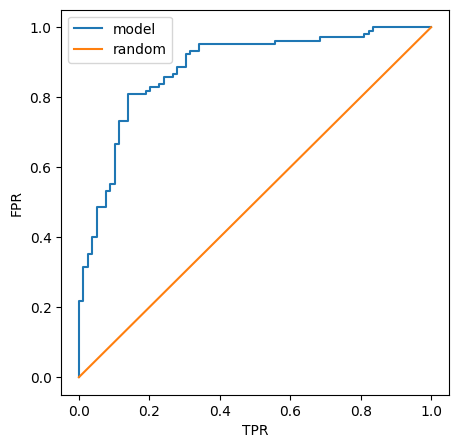

In [186]:
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,label='model')
plt.plot([0,1],[0,1],label = 'random')
plt.ylabel('FPR')
plt.xlabel('TPR')
plt.legend()

In [187]:
auc(fpr,tpr)

0.8818565400843881

In [190]:
y_pred_hard = model.predict(X_val_scaled)
confusion_matrix(y_val,y_pred_hard)

array([[65, 14],
       [20, 85]])

In [192]:
print(classification_report(y_val, y_pred_hard))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79        79
           1       0.86      0.81      0.83       105

    accuracy                           0.82       184
   macro avg       0.81      0.82      0.81       184
weighted avg       0.82      0.82      0.82       184

